In [39]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegressionCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import shap
import warnings
warnings.filterwarnings('ignore')

In [40]:
# CONFIGURATION
base_path = "C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/Auto Data/Merged/"
sc_file = "sc_cleaned_combined_2013_2022.csv"
tn_file = "TN_PROCESSED_corrected_v2.csv"
pa_file = "PA_PROCESSED_corrected.csv"
fars_file = "FARS_combined_cleaned_2013-2023_v2.csv"

In [41]:
# TEST MODE: Toggle ON (True) or OFF (False)
test_mode = True
sample_frac = 0.05 if test_mode else 1.0

In [42]:
# HELPER FUNCTIONS

def load_dataset(filepath):
    if os.path.exists(filepath):
        df = pd.read_csv(filepath, dtype=str)
        print(f"Loaded {filepath} with shape {df.shape}")
        return df.sample(frac=sample_frac, random_state=42).reset_index(drop=True)
    else:
        raise FileNotFoundError(f"File not found: {filepath}")

def preprocess_dataset(df):
    df["crash_date"] = pd.to_datetime(df["crash_date"], errors='coerce')
    df["severity_level"] = pd.to_numeric(df["severity_level"], errors='coerce')
    df["driver_age"] = pd.to_numeric(df["driver_age"], errors='coerce')
    df["opioid_flag"] = pd.to_numeric(df["opioid_flag"], errors='coerce')
    df["alcohol_flag"] = pd.to_numeric(df["alcohol_flag"], errors='coerce')
    df["any_drug_flag"] = pd.to_numeric(df["any_drug_flag"], errors='coerce')
    return df

# Severity mapping
severity_remap = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 8: 5, 9: 6}
reverse_remap = {v: k for k, v in severity_remap.items()}
severity_labels = {
    0: "Property Damage Only",
    1: "Fatal",
    2: "Suspected Serious Injury",
    3: "Suspected Minor Injury",
    4: "Possible Injury",
    5: "Injury – Unknown Severity",
    6: "Unknown if Injured"
}

# --- LOAD DATA ---
sc_df = load_dataset(os.path.join(base_path, sc_file))
tn_df = load_dataset(os.path.join(base_path, tn_file))
pa_df = load_dataset(os.path.join(base_path, pa_file))
fars_df = load_dataset(os.path.join(base_path, fars_file))

merged_df = pd.concat([sc_df, tn_df, pa_df], ignore_index=True)
merged_df.to_csv(os.path.join(base_path, "merged_dataset.csv"), index=False)
print(f"Merged dataset saved with shape {merged_df.shape}")

merged_df = preprocess_dataset(merged_df)
fars_df = preprocess_dataset(fars_df)

Loaded C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/Auto Data/Merged/sc_cleaned_combined_2013_2022.csv with shape (2526020, 14)
Loaded C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/Auto Data/Merged/TN_PROCESSED_corrected_v2.csv with shape (9502214, 15)
Loaded C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/Auto Data/Merged/PA_PROCESSED_corrected.csv with shape (5538978, 15)
Loaded C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/Auto Data/Merged/FARS_combined_cleaned_2013-2023_v2.csv with shape (148042, 24)
Merged dataset saved with shape (878361, 15)


In [43]:
# PIPELINE FUNCTION
def full_pipeline(df, dataset_name="Dataset"):
    print(f"\n====== Running Pipeline for {dataset_name} ======")

    df = df.sort_values('crash_date')
    train_df = df[(df['crash_date'].dt.year >= 2013) & (df['crash_date'].dt.year <= 2020)]
    valid_df = df[(df['crash_date'].dt.year == 2021)]
    test_df = df[(df['crash_date'].dt.year == 2022)]

    features = ['driver_age', 'alcohol_flag', 'any_drug_flag']

    # --- Baseline Logistic Regression ---
    X_train = train_df[features].fillna(0)
    y_train = train_df['opioid_flag']
    X_test = test_df[features].fillna(0)
    y_test = test_df['opioid_flag']

    baseline_model = LogisticRegression(max_iter=1000)
    baseline_model.fit(X_train, y_train)

    print("\n=== Logistic Regression Performance ===")
    print(classification_report(y_test, baseline_model.predict(X_test)))
    print("ROC-AUC:", roc_auc_score(y_test, baseline_model.predict_proba(X_test)[:,1]))

    # --- XGBoost Severity Prediction ---
    y_train_sev = train_df['severity_level'].map(severity_remap)
    y_test_sev = test_df['severity_level'].map(severity_remap)

    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    xgb_model.fit(X_train, y_train_sev)
    y_pred_sev = xgb_model.predict(X_test)

    # Reverse map predictions
    y_pred_final = pd.Series(y_pred_sev).map(reverse_remap)

    print("\n=== XGBoost Performance for Severity Prediction ===")
    print(classification_report(y_test, y_pred_final))

    # --- SHAP Values ---
    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer(X_test)

    print("\n=== SHAP Summary for Severity Prediction ===")
    shap.summary_plot(
        shap_values, 
        features=X_test.rename(columns={
            'driver_age': 'Driver Age', 
            'alcohol_flag': 'Alcohol Flag', 
            'any_drug_flag': 'Any Drug Flag'
        }),
        show=True
    )

    # --- Prescriptive Analysis ---
    prescriptive_pipeline(df, dataset_name)

In [44]:
# County Risk Segmentation

def county_level_risk_analysis(df, dataset_name):
    print(f"\n[Prescriptive Analysis: {dataset_name}] County-Level Risk Analysis")

    serious_crashes = df[df['severity_level'].isin([1,2,3,4])]

    risk_summary = serious_crashes.groupby('county_fips').agg(
        total_crashes=('crash_id', 'count'),
        avg_driver_age=('driver_age', 'mean'),
        opioid_involvement=('opioid_flag', 'mean'),
        alcohol_involvement=('alcohol_flag', 'mean'),
        drug_involvement=('any_drug_flag', 'mean')
    ).reset_index()

    X_cluster = risk_summary[['opioid_involvement', 'alcohol_involvement', 'drug_involvement']]
    kmeans = KMeans(n_clusters=3, random_state=42)
    risk_summary['risk_tier'] = kmeans.fit_predict(X_cluster)

    print(risk_summary.head())

    plt.figure(figsize=(10,6))
    sns.scatterplot(data=risk_summary, x='opioid_involvement', y='alcohol_involvement', hue='risk_tier', palette='coolwarm')
    plt.title(f"{dataset_name}: County Risk Clusters (Opioids vs Alcohol)")
    plt.xlabel("Opioid Involvement Rate")
    plt.ylabel("Alcohol Involvement Rate")
    plt.grid()
    plt.legend(title='Risk Tier')
    plt.show()

    return risk_summary

In [45]:
# Driver Risk Modeling

def driver_level_risk_scoring(df, dataset_name):
    print(f"\n[Prescriptive Analysis: {dataset_name}] Driver-Level Risk Modeling")

    features = ['driver_age', 'opioid_flag', 'alcohol_flag', 'any_drug_flag']
    target = 'severity_level'

    X = df[features].fillna(0)
    y = df[target]

    model = LogisticRegressionCV(cv=5, max_iter=1000, scoring='f1_weighted')
    model.fit(X, y)

    coef_summary = pd.DataFrame({
        'Feature': features,
        'Coefficient': model.coef_[0]
    }).sort_values('Coefficient', ascending=False)

    print(coef_summary)

    sns.barplot(x='Coefficient', y='Feature', data=coef_summary, palette='viridis')
    plt.title(f"{dataset_name}: Driver Risk Factors Influence on Severity")
    plt.grid()
    plt.show()

    return model

In [46]:
# Prescriptive Recommendations

def prescriptive_recommendations():
    print("\nPrescriptive Recommendation Summary:")
    print("1. Counties in the highest opioid/alcohol cluster should receive targeted awareness campaigns.")
    print("2. Driver age 16-25 with any drug/alcohol flag are top candidates for insurance premium surcharges.")
    print("3. Severity prediction models can be integrated into claims triaging systems for faster prioritization.")
    print("4. Continuous model retraining every 2-3 years recommended due to evolving opioid crisis patterns.")

def prescriptive_pipeline(df, dataset_name):
    county_summary = county_level_risk_analysis(df, dataset_name)
    driver_model = driver_level_risk_scoring(df, dataset_name)
    prescriptive_recommendations()


====== Running Pipeline for Merged SC+TN+PA ======

=== Logistic Regression Performance ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58178
           1       0.00      0.00      0.00        14

    accuracy                           1.00     58192
   macro avg       0.50      0.50      0.50     58192
weighted avg       1.00      1.00      1.00     58192

ROC-AUC: 0.7740389101427638

=== XGBoost Performance for Severity Prediction ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58178
           1       0.03      0.21      0.06        14
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0

    accuracy                           1.00     58192
   macro avg       0.17      0.20      0.18     58192
weighted av

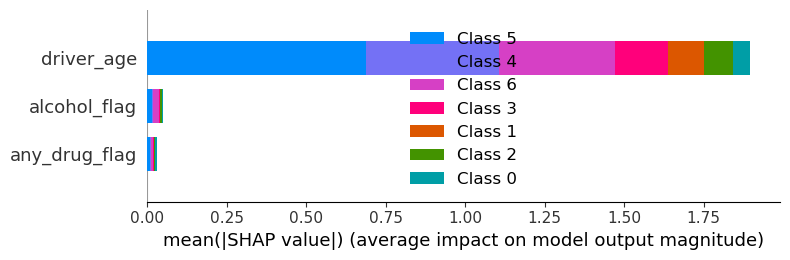


[Prescriptive Analysis: Merged SC+TN+PA] County-Level Risk Analysis
  county_fips  total_crashes  avg_driver_age  opioid_involvement  \
0           1            740       37.329730            0.001351   
1         1.0            802       38.930175            0.011222   
2          11            345       35.434783            0.002899   
3        11.0            774       39.368217            0.003876   
4          13            213       35.436620            0.014085   

   alcohol_involvement  drug_involvement  risk_tier  
0             0.000000          0.000000          0  
1             0.081047          0.059850          1  
2             0.000000          0.000000          0  
3             0.124031          0.073643          2  
4             0.000000          0.000000          0  


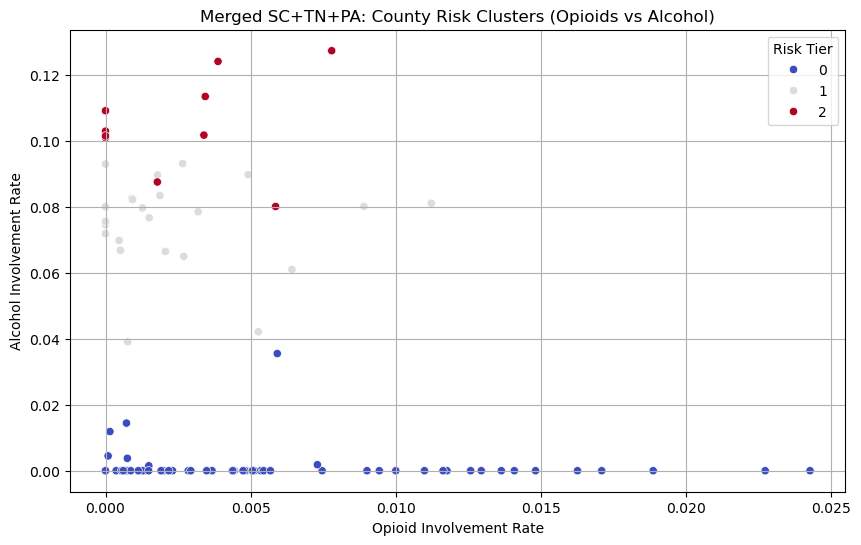


[Prescriptive Analysis: Merged SC+TN+PA] Driver-Level Risk Modeling
         Feature  Coefficient
0     driver_age    -0.006987
1    opioid_flag    -0.302677
2   alcohol_flag    -0.841238
3  any_drug_flag    -1.138613


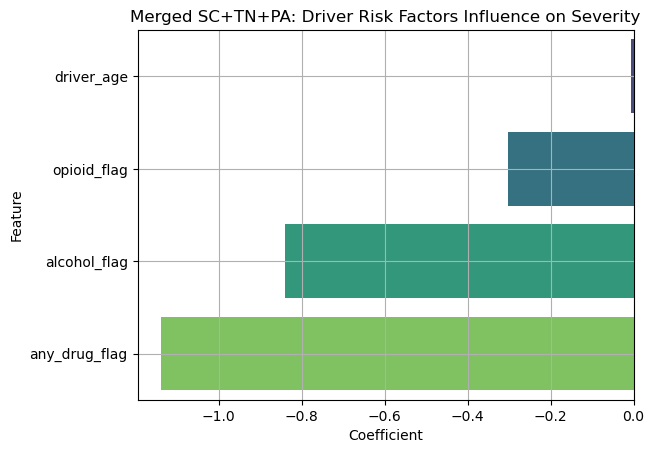


Prescriptive Recommendation Summary:
1. Counties in the highest opioid/alcohol cluster should receive targeted awareness campaigns.
2. Driver age 16-25 with any drug/alcohol flag are top candidates for insurance premium surcharges.
3. Severity prediction models can be integrated into claims triaging systems for faster prioritization.
4. Continuous model retraining every 2-3 years recommended due to evolving opioid crisis patterns.


In [47]:
# RUN PIPELINES
full_pipeline(merged_df, dataset_name="Merged SC+TN+PA")
#full_pipeline(fars_df, dataset_name="FARS")